# Breast Cancer Prediction

### Importing Libraries

In [1]:
from sklearn.model_selection import train_test_split, validation_curve, learning_curve, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

### Reading Data and Knowing the Primaries

In [2]:
df = pd.read_csv(r'cancer.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.shape

(569, 33)

In [4]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [5]:
total_memory_usage = df.memory_usage().sum() / 1024**2

print(f"Total memory usage: {total_memory_usage:.2f} MB")

Total memory usage: 0.14 MB


In [6]:
df.duplicated().sum()

0

### Dropping Unwanted Columns

In [7]:
# These two features seems to be of no value for our analysis or model building. So dropping them.

df.drop(['id', 'Unnamed: 32'], axis = 1, inplace = True)

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

### What kinda features do we have?

In [9]:
df.nunique()

diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtype: int64

No discrete features and only continuous and a nominal categorical variable it seems(that too is our target variable);

So, in all we are gonna deal with a dataset which has only continuous variables

### Do we have outliers in considerable proportion? If yes do they matter?

In [10]:
def count_outliers(df):
    outliers = {}
    for col in df.select_dtypes(include='number').columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + (1.5 * iqr)
        lower_bound = q1 - (1.5 * iqr)
        outliers[col] = len(df[(df[col] > upper_bound) | (df[col] < lower_bound)])
    return outliers

In [11]:
outliers = count_outliers(df)
outliers

{'radius_mean': 14,
 'texture_mean': 7,
 'perimeter_mean': 13,
 'area_mean': 25,
 'smoothness_mean': 6,
 'compactness_mean': 16,
 'concavity_mean': 18,
 'concave points_mean': 10,
 'symmetry_mean': 15,
 'fractal_dimension_mean': 15,
 'radius_se': 38,
 'texture_se': 20,
 'perimeter_se': 38,
 'area_se': 65,
 'smoothness_se': 30,
 'compactness_se': 28,
 'concavity_se': 22,
 'concave points_se': 19,
 'symmetry_se': 27,
 'fractal_dimension_se': 28,
 'radius_worst': 17,
 'texture_worst': 5,
 'perimeter_worst': 15,
 'area_worst': 35,
 'smoothness_worst': 7,
 'compactness_worst': 16,
 'concavity_worst': 12,
 'concave points_worst': 0,
 'symmetry_worst': 23,
 'fractal_dimension_worst': 24}

In [12]:
total_rows = len(df)

percentages = [round(((value / total_rows) * 100), 2) for value in outliers.values()]

print(sorted(percentages, reverse = True))

[11.42, 6.68, 6.68, 6.15, 5.27, 4.92, 4.92, 4.75, 4.39, 4.22, 4.04, 3.87, 3.51, 3.34, 3.16, 2.99, 2.81, 2.81, 2.64, 2.64, 2.64, 2.46, 2.28, 2.11, 1.76, 1.23, 1.23, 1.05, 0.88, 0.0]


Though there's a feature which seems to have more than 10% of datapoints as outliers and many other features having around 5% of datapoints as outliers, in this particular dataset, outliers can be allowed to an extent as there would be exceptional cases where any of the mentioned features could go abnormal and those as well needs to be classified and shouldn't go uncounted.... So leaving them as it is as no alarming amount of outliers present in the dataset.

### Do we have to scale the data?

In [13]:
def get_column_ranges(df):
    ranges = {}
    for column in df.select_dtypes(include='number').columns:
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = column_max - column_min
        ranges[column] = [column_min, column_max, column_range]
    return ranges

In [14]:
ranges = get_column_ranges(df)

for column, values in ranges.items():
    print(f"Column: {column}")
    print(f"Minimum: {values[0]}, Maximum: {values[1]}, Range: {values[2]}")
    print()

Column: radius_mean
Minimum: 6.981, Maximum: 28.11, Range: 21.128999999999998

Column: texture_mean
Minimum: 9.71, Maximum: 39.28, Range: 29.57

Column: perimeter_mean
Minimum: 43.79, Maximum: 188.5, Range: 144.71

Column: area_mean
Minimum: 143.5, Maximum: 2501.0, Range: 2357.5

Column: smoothness_mean
Minimum: 0.05263, Maximum: 0.1634, Range: 0.11076999999999998

Column: compactness_mean
Minimum: 0.01938, Maximum: 0.3454, Range: 0.32602

Column: concavity_mean
Minimum: 0.0, Maximum: 0.4268, Range: 0.4268

Column: concave points_mean
Minimum: 0.0, Maximum: 0.2012, Range: 0.2012

Column: symmetry_mean
Minimum: 0.106, Maximum: 0.304, Range: 0.198

Column: fractal_dimension_mean
Minimum: 0.04996, Maximum: 0.09744, Range: 0.04748

Column: radius_se
Minimum: 0.1115, Maximum: 2.873, Range: 2.7615000000000003

Column: texture_se
Minimum: 0.3602, Maximum: 4.885, Range: 4.5248

Column: perimeter_se
Minimum: 0.757, Maximum: 21.98, Range: 21.223

Column: area_se
Minimum: 6.802, Maximum: 542.2, R

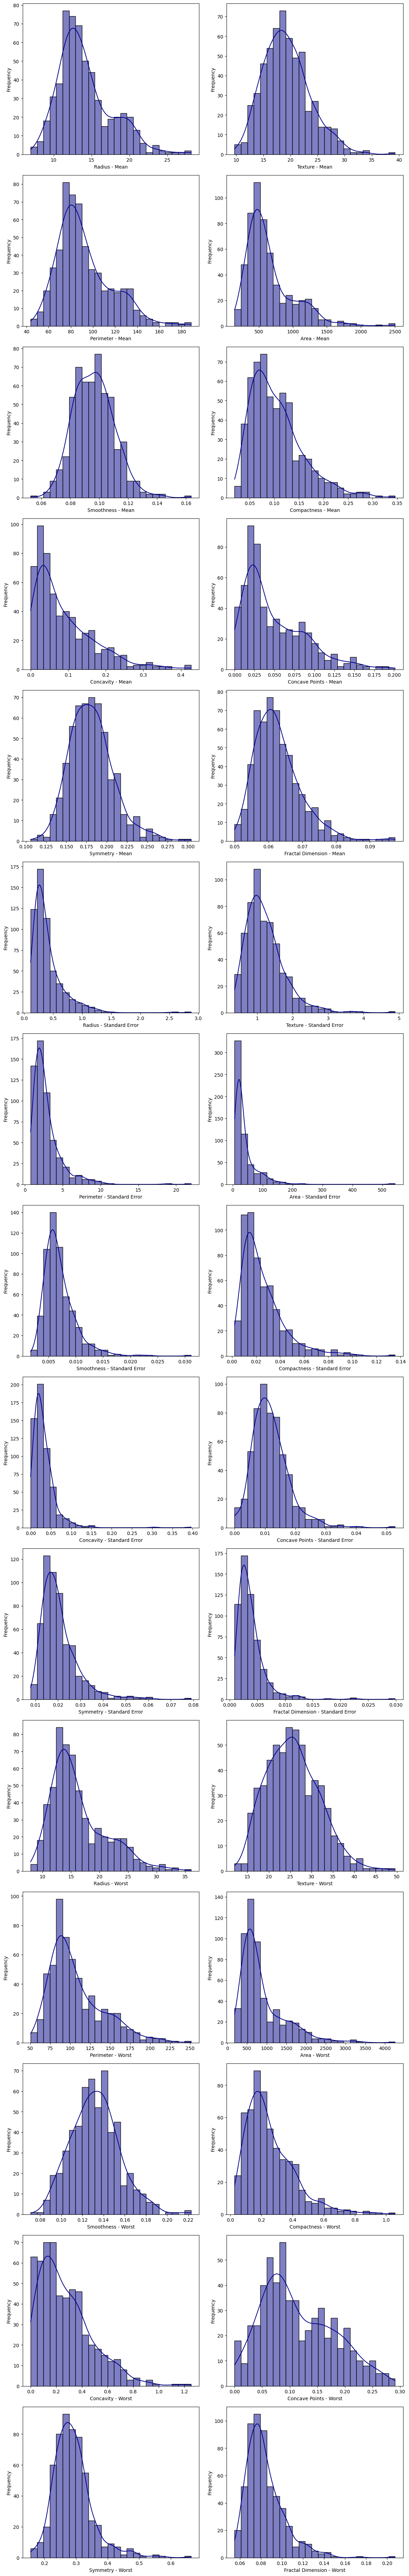

In [15]:
num_plots = len(df.iloc[:, 1:].columns)

num_rows = (num_plots + 1) // 2  # Number of rows for subplots

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))

for i, feature in enumerate(df.iloc[:, 1:].columns):
    data = df.copy()

    row = i // 2
    col = i % 2
    ax = axes[row, col]

    sns.histplot(data[feature], ax=ax, bins=25, kde=True, color='darkblue')  # Set color to 'darkblue' for a darker curve
    ax.set_xlabel(feature.replace('_', ' - ').title().replace('Se', 'Standard Error').replace('Fractal - Dimension', 'Fractal Dimension'))
    ax.set_ylabel("Frequency")

# Remove any empty subplots
if num_plots < num_rows * 2:
    fig.delaxes(axes[num_rows-1, 1])

plt.tight_layout()
plt.show()

Almost all of these distributions seems to be either of normal or lognormal dist.... So, no need of any scaling as such if you consider the distribution.... But when you see the scale of certain features, they are not equivalent to other features.... So, it would be good if we scale the features.

### Feature, Target and Train, Test Split

In [16]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### Scaling

In [18]:
scaler = StandardScaler()
X_train_scaled =scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Imbalance check and Balancing

In [19]:
y_train.value_counts()

diagnosis
B    290
M    165
Name: count, dtype: int64

<Axes: ylabel='count'>

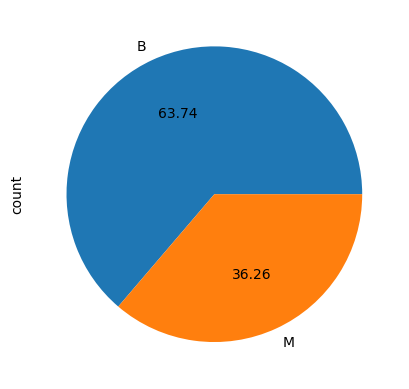

In [20]:
y_train.value_counts().plot.pie(autopct = '%.2f')

In [21]:
ros = RandomOverSampler(sampling_strategy="not majority")
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

In [22]:
y_res.value_counts()

diagnosis
B    290
M    290
Name: count, dtype: int64

<Axes: ylabel='count'>

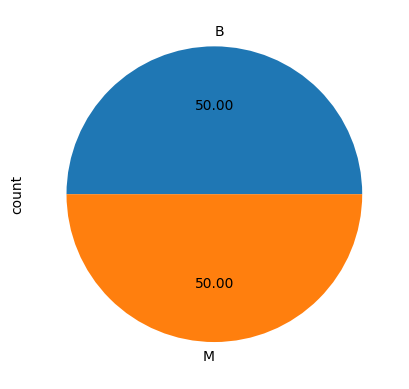

In [23]:
y_res.value_counts().plot.pie(autopct='%.2f')

### Model Building

#### Object Creation and Fitting

In [24]:
classifier = SVC(kernel="rbf")
classifier.fit(X_res, y_res)

SVC()

#### Cross Validation

In [25]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [26]:
param_range = np.logspace(-3, 3, 7)
train_scores, val_scores = validation_curve(classifier, X_res, y_res, param_name="C", param_range=param_range, cv=kfold)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

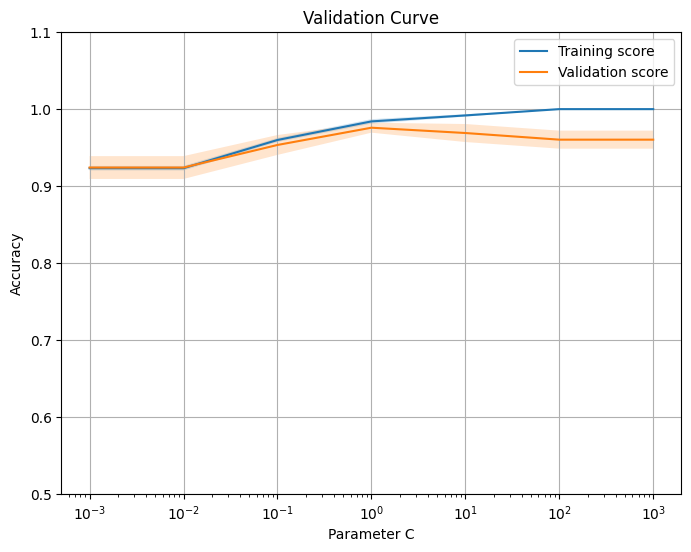

No significant overfitting or underfitting


In [27]:
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_scores_mean, label='Training score')
plt.plot(param_range, val_scores_mean, label='Validation score')
plt.fill_between(x = param_range, y1 = train_scores_mean - train_scores_std, y2 = train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(x = param_range, y1 = val_scores_mean - val_scores_std, y2 = val_scores_mean + val_scores_std, alpha=0.2)

plt.xscale('log')
plt.ylim(0.5, 1.1)

plt.xlabel('Parameter C')
plt.ylabel('Accuracy')

plt.title('Validation Curve')

plt.legend(loc='best')
plt.grid(True)
plt.show()

if np.max(val_scores_mean) == 1.0:
    print("Overfitting")
elif np.min(val_scores_mean) <= 0.5:
    print("Underfitting")
else:
    print("No significant overfitting or underfitting")

In [28]:
train_sizes, train_scores, val_scores = learning_curve(classifier, X_res, y_res, cv=kfold, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

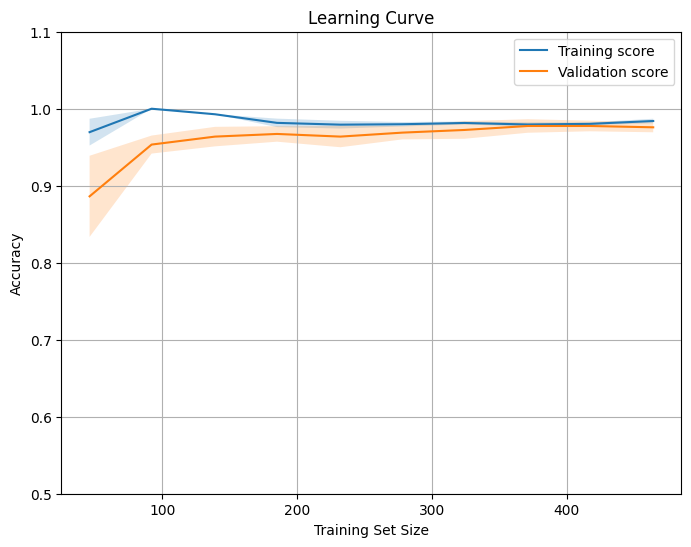

No significant overfitting or underfitting


In [29]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, val_scores_mean, label='Validation score')
plt.fill_between(x = train_sizes, y1 = train_scores_mean - train_scores_std, y2 = train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(x = train_sizes, y1 = val_scores_mean - val_scores_std, y2 = val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')

plt.ylim(0.5, 1.1)

plt.title('Learning Curve')

plt.legend(loc='best')
plt.grid(True)
plt.show()

if np.max(val_scores_mean) == 1.0:
    print("Overfitting")
elif np.min(val_scores_mean) <= 0.5:
    print("Underfitting")
else:
    print("No significant overfitting or underfitting")

#### Other Accuracy Metrics After Prediction

In [30]:
y_pred = classifier.predict(X_test_scaled)

print(f'\nAccuracy Score: {accuracy_score(y_test, y_pred)}', end = f"\n{'_'*60}\n\n")

print(f'Confusion Matrix:\n\n {confusion_matrix(y_test, y_pred)}', end = f"\n{'_'*60}\n\n")

print(f'Classification Report:\n\n {classification_report(y_test, y_pred)}')


Accuracy Score: 0.9736842105263158
____________________________________________________________

Confusion Matrix:

 [[65  2]
 [ 1 46]]
____________________________________________________________

Classification Report:

               precision    recall  f1-score   support

           B       0.98      0.97      0.98        67
           M       0.96      0.98      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



As False Negative matters the most here, as we can see, the confusion matrix shows that there is only 1 False Negative in all which is around 1% of the test set. That sounds good...

#### Pickle File Creation

In [31]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(classifier, "classifier.pkl")

['classifier.pkl']

In [32]:
X_test.to_csv('X_test.csv', index= False)